In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [153]:
#hyperparameter & path setting
batch_size=128
lr=5e-4
latent_dim=8
epochs=20

data_path='/data/home/ppleeqq/data/credit/'
model_path='./ae_save_models/'
log_path='./ae_logs/'
Train=True

#랜덤 시드 설정
seed = 40
torch.manual_seed(seed)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [154]:
# 데이터 불러오기
data = pd.read_csv(data_path+'train.csv')
data =data.drop(columns=['ID'])

val_data = pd.read_csv(data_path+'val.csv')
val_y=val_data['Class']
val_data =val_data.drop(columns=['ID','Class'])

In [155]:
#잘 불러왔는지, class 잘 잘랐는지 확인
print(data[0:3], val_data[0:3], val_y[0:3])
#input row와 column 확인. 오토인코더 모델에 넣어야 함.
print(data.shape)


         V1        V2        V3        V4        V5        V6        V7  \
0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
2 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.247676 -1.514654  0.207643  ...  0.247998  0.771679  0.909412 -0.689281   
1  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274 -0.190321 -1.175575   
2  0.260314 -0.568671 -0.371407  ... -0.208254 -0.559825 -0.026398 -0.371427   

        V25       V26       V27       V28       V29       V30  
0 -0.327642 -0.139097 -0.055353 -0.059752  4.983721 -0.994972  
1  0.647376 -0.221929  0.062723  0.061458  1.418291 -0.994972  
2 -0.232794  0.105915  0.253844  0.081080 -0.256131 -0.994960  

[3 rows x 30 columns]          V1        V2        V3        V4        V5        V6        V7  \
0 -0.338262  1.119593  1

In [156]:
#data scaling. autoencoder에서 마지막 활성화 층으로 sigmoid를 이용할 것이므로 MinMaxScaler 사용.
#train data에 피팅한 scaler에 train과 val를 scaling

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)
    

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = torch.tensor(scaled_data, dtype=torch.float32)
dataloader = DataLoader(scaled_data, batch_size=batch_size, shuffle=True)

scaled_val_data = scaler.transform(val_data)
scaled_val_data = torch.tensor(scaled_val_data, dtype=torch.float32)
val_dataloader = DataLoader(scaled_val_data, batch_size=batch_size)

In [78]:
# 오토인코더 모델 정의 활성화 층도 없고 linear 두개로 이루어짐.
class BasicAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [79]:
# input column이 30임을 아까 확인했으므로 일단 8차원으로 줄여보자.
# 모델이 잘 적합되었는지 확인
model=BasicAutoencoder(30,8)
print(model)

BasicAutoencoder(
  (encoder): Linear(in_features=30, out_features=8, bias=True)
  (decoder): Linear(in_features=8, out_features=30, bias=True)
)


In [80]:
#손실함수, optimizer 정의 일단 제일 기본으로 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
total_loss = 0.0
total_batches = 0
average_loss=[]

# 학습
if Train : 
    for epoch in range(epochs):
        now1=datetime.datetime.now()
        for batch in dataloader:
            #모델 파라미터의 gradient 초기화
            optimizer.zero_grad()
            #dataloader에서 한 row씩 가져오기
            inputs = batch.to(device)
            #모델에 넣기
            model=model.to(device)
            _ , outputs = model(inputs)
            #loss 계산
            loss = criterion(outputs, inputs)
            #loss를 사용해 backpropagation으로 gradient 계산
            loss.backward()
            #계산한 gradient로 모델의 parameter 업데이트
            optimizer.step()

            total_loss += loss.item()
            total_batches += 1

        if epoch==0: 
            now2=datetime.datetime.now()
            print(f"예상완료시각: {now2+(now2-now1)*epochs}")    
        average_loss.append(total_loss / total_batches)
        print(f"Epoch: {epoch}, Average Loss: {total_loss / total_batches:.6f}")

    now=datetime.datetime.now()
    formatted=now.strftime('%m_%d_%H_%M')

    model_name = f'anomaly_autoencoder_Fraud_{formatted}.pt'
    torch.save(model.state_dict(),  model_path + model_name)
    print(f'Model saved at { model_path + model_name}')

else:
    model_name = f'anomaly_autoencoder_Fraud_07_06_13_48.pt'
    model.load_state_dict(torch.load( model_path +  model_name))
    print('model parameter: ',model.parameters())



예상완료시각: 2023-07-07 17:22:24.479806
Epoch: 0, Average Loss: 0.037190
Epoch: 1, Average Loss: 0.020686
Epoch: 2, Average Loss: 0.014742
Epoch: 3, Average Loss: 0.011621
Epoch: 4, Average Loss: 0.009704
Epoch: 5, Average Loss: 0.008392
Epoch: 6, Average Loss: 0.007424
Epoch: 7, Average Loss: 0.006672
Epoch: 8, Average Loss: 0.006067
Epoch: 9, Average Loss: 0.005570
Epoch: 10, Average Loss: 0.005153
Epoch: 11, Average Loss: 0.004799
Epoch: 12, Average Loss: 0.004495
Epoch: 13, Average Loss: 0.004233
Epoch: 14, Average Loss: 0.004005
Epoch: 15, Average Loss: 0.003804
Epoch: 16, Average Loss: 0.003627
Epoch: 17, Average Loss: 0.003470
Epoch: 18, Average Loss: 0.003328
Epoch: 19, Average Loss: 0.003201
Model saved at ./ae_save_models/anomaly_autoencoder_Fraud_07_07_17_22.pt


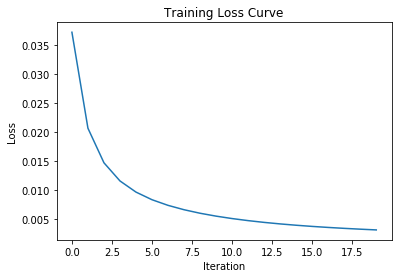

In [82]:
# loss가 잘 줄어드는지 확인
plt.figure()
plt.plot(average_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

### Anomaly detection에 사용해보자

In [200]:
# validation set으로 확인해보자.
anomaly_scores = []
latent= np.empty((0,8))
np_x=np.empty((0,30))
np_xhat=np.empty((0,30))
i=0

with torch.no_grad():
    # parameter update 하지 말라고 써주는거
    model.eval()
    for data in val_dataloader:
        i+=1
        model=model.to(device)
        inputs = data.to(device)
        encoded, outputs = model(inputs)

        # reconstruction loss
        for i in range(outputs.shape[0]):
            l = criterion(outputs[i], inputs[i])
            anomaly_scores.append(l.item())

        if i %1000 == 0 : print(f'Batch: {i}/{len(val_dataloader)}, loss: {l:.4f}')
        # Append the loss to the anomaly_scores list
        latent=np.vstack((latent,encoded.cpu().numpy()))
        np_x=np.vstack((np_x,inputs.cpu().numpy()))
        np_xhat=np.vstack((np_xhat,outputs.cpu().numpy()))

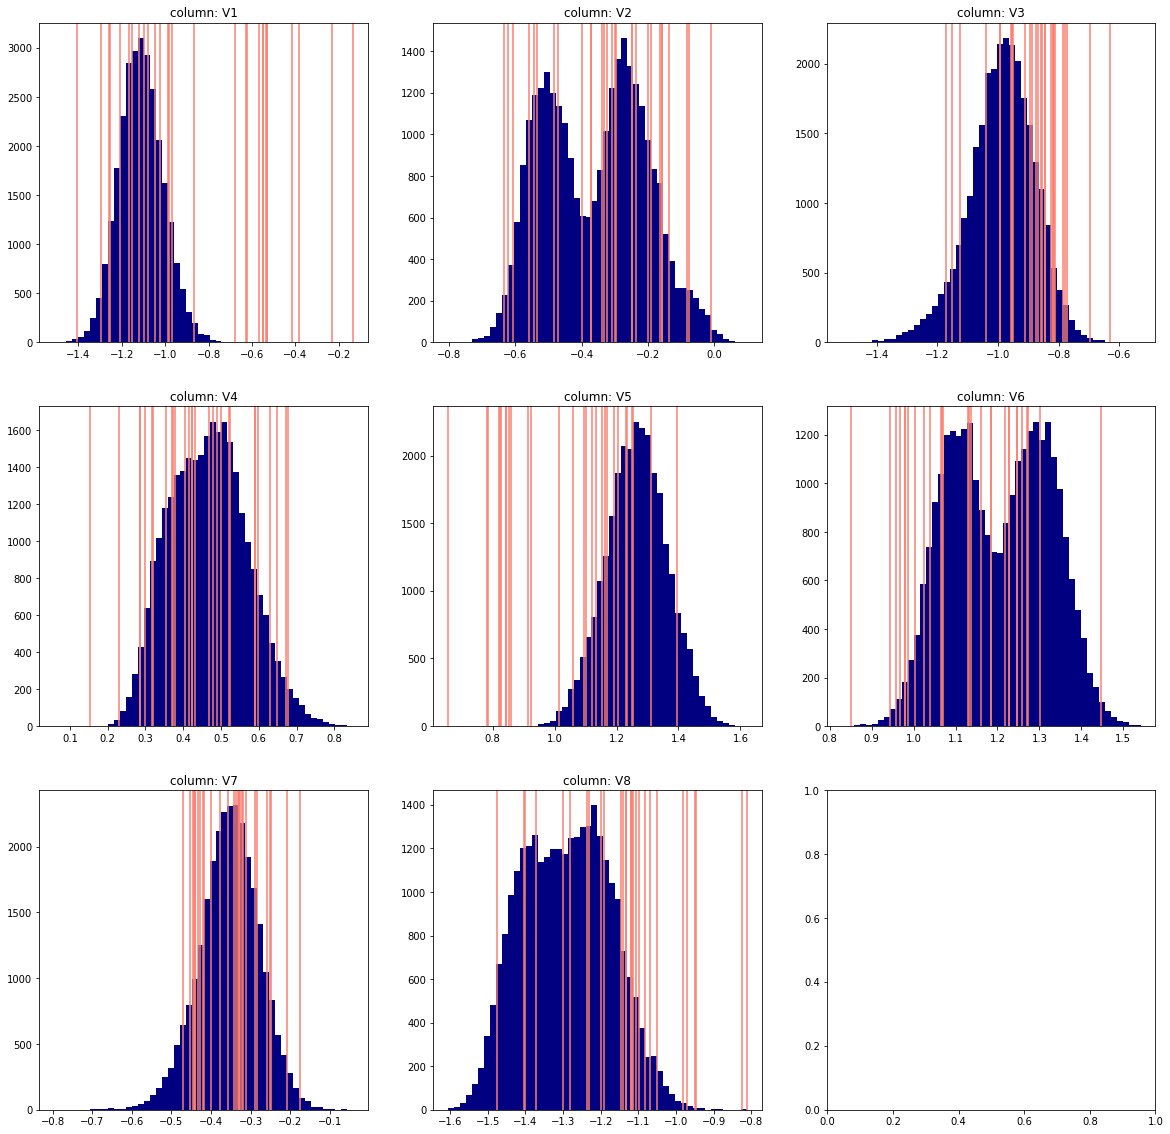

In [201]:
# 차원축소 했을 때 representation space에서의 anomal과 nomal 값들을 확인해보자

latent_fraud=latent[val_y==1,:]

#sub plot 객체 지정
sub_plots=plt.subplots(3,3,figsize=(20,20))
fig = sub_plots[0]
graph = sub_plots[1]

#for문 만들기 위한 수 지정
v=latent.shape[1]
s=latent_fraud.shape[0]

for i in range(0,v):
    a=i//3
    b=i%3
    graph[a][b].hist(latent[:,i],bins=50,color='navy')
    graph[a][b].set_title(f'column: V{i+1}')
    for j in range(0,s-1):
        graph[a][b].axvline(latent_fraud[j,i],color="salmon")

plt.show()   

In [202]:
latent.shape[1]

8

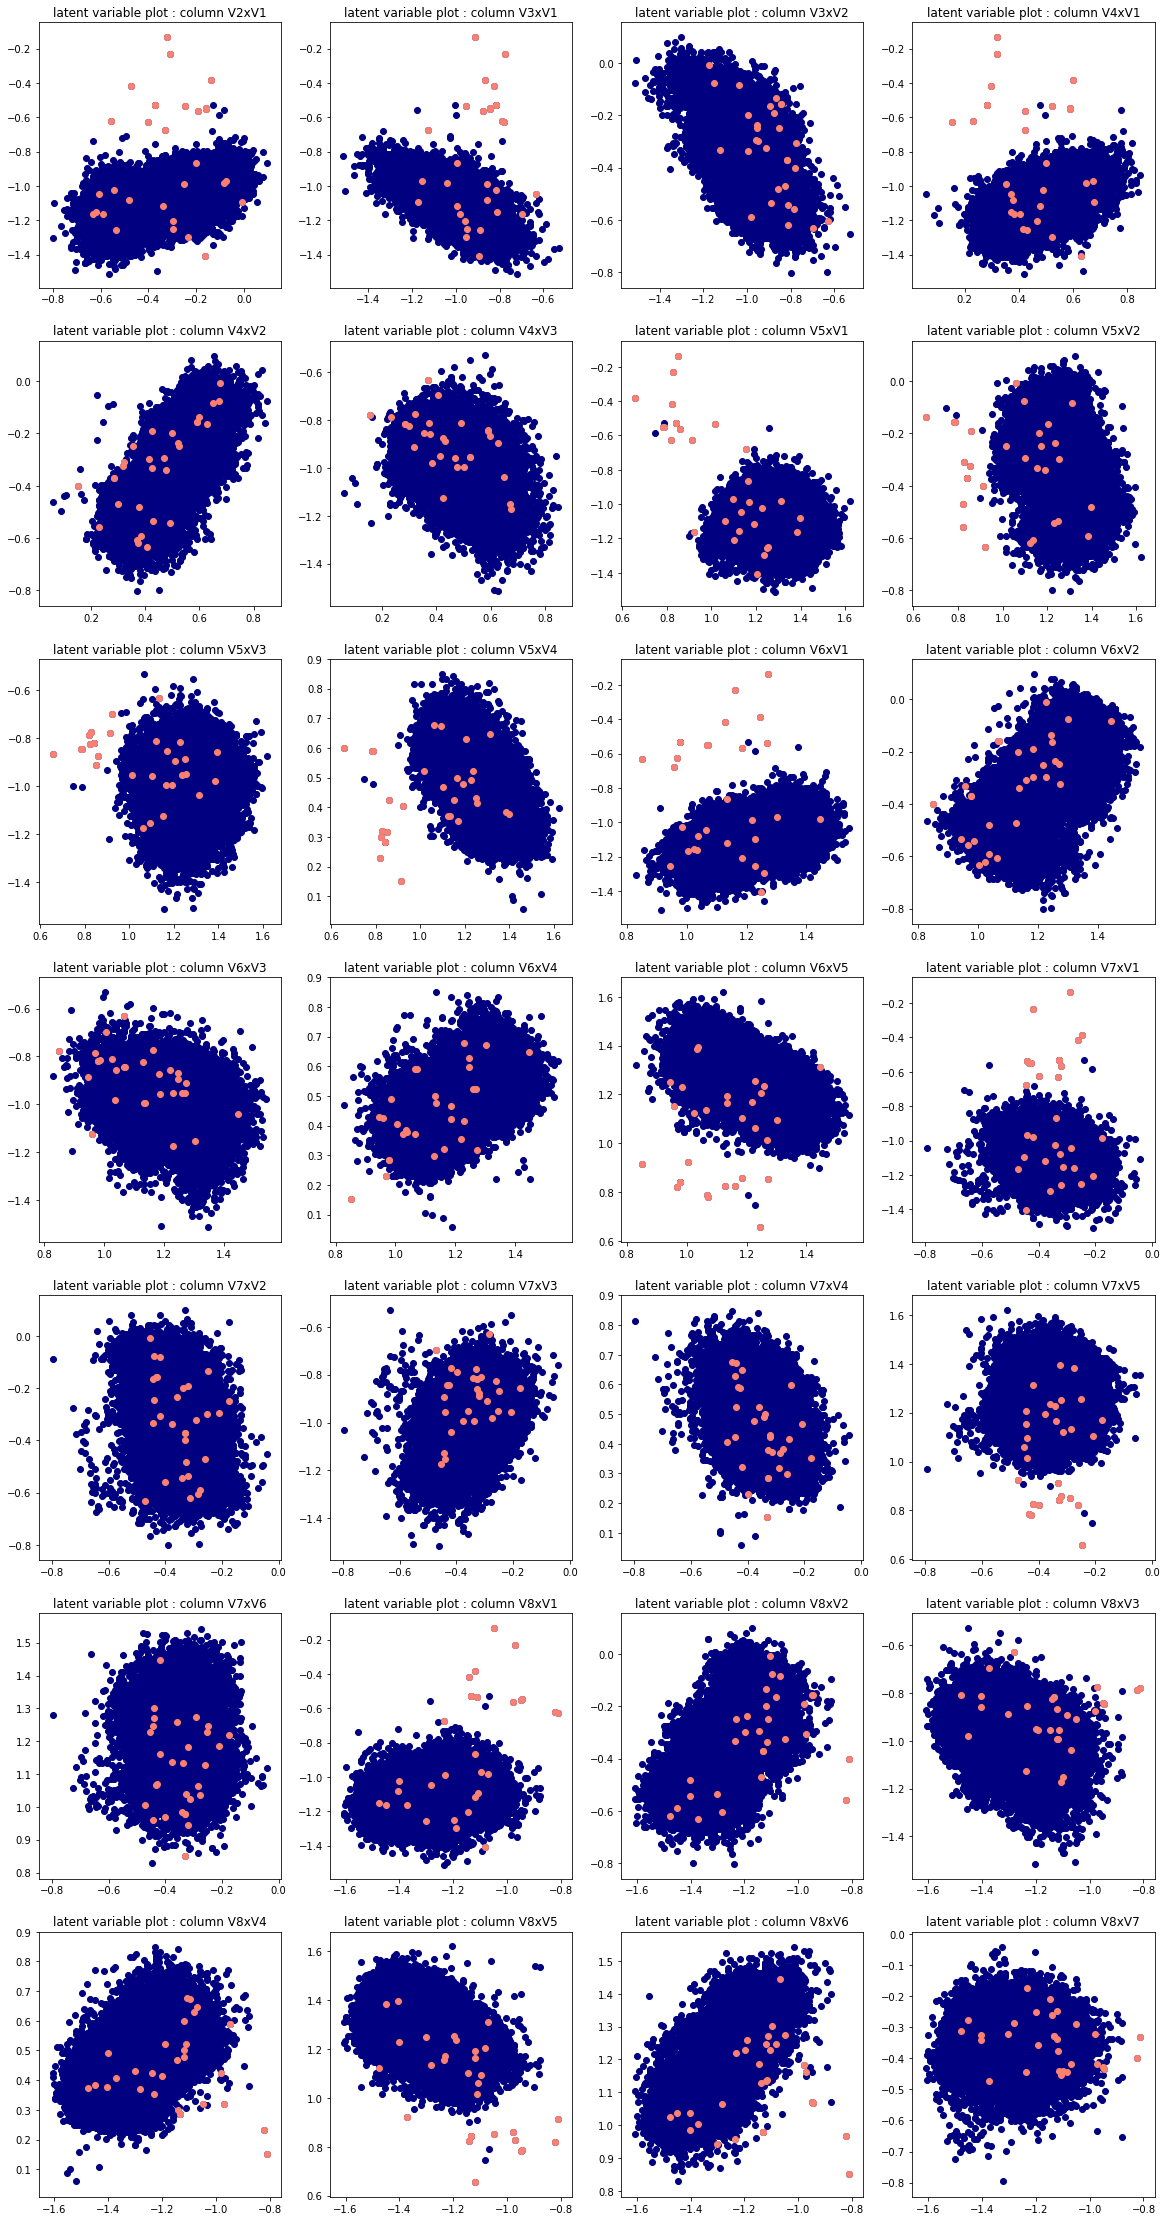

In [203]:
# 차원축소 했을 때 representation space 그림을 그려보자.

#sub plot 객체 지정
sub_plots=plt.subplots(7,4,figsize=(20,40))
fig = sub_plots[0]
graph = sub_plots[1]

#for문 만들기 위한 수 지정
w=0
v=latent.shape[1]

for i in range(0,v):
    for j in range(0,i):
        a=w//4
        b=w%4
        graph[a][b].scatter(latent[:,i], latent[:,j],color='navy')
        graph[a][b].set_title(f'latent variable plot : column V{i+1}xV{j+1}')
        graph[a][b].scatter(latent[val_y==1,i],latent[val_y==1,j],color="salmon")
        w+=1

plt.show()   
# 축소한 차원에서 이상치를 잘 분류하는 column도 있고 그렇지 못한 column 도 있음. 
# 모든 column이 잘 분류해준다면 best지만 아직 그러지는 않음.

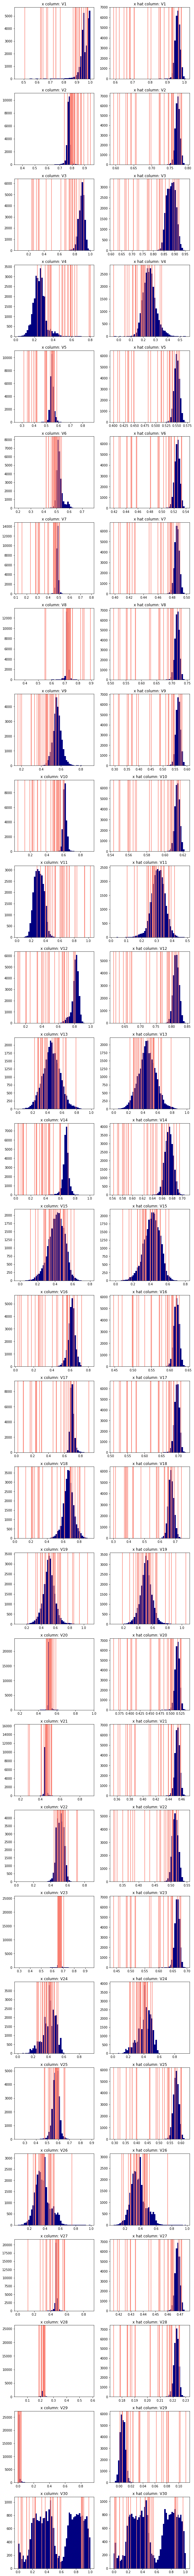

In [204]:
# normal과 anomal값들이 Autoencoder를 거쳐서 어떻게 변하는지 보자.

xhat_fraud=np_xhat[val_y==1,:]
x_fraud=np_x[val_y==1,:]
#sub plot 객체 지정
sub_plots=plt.subplots(30,2,figsize=(10,150))
fig = sub_plots[0]
graph = sub_plots[1]

#for문 만들기 위한 수 지정
v=np_xhat.shape[1]
s=xhat_fraud.shape[0]

for i in range(0,v):
    graph[i][1].hist(np_xhat[:,i],bins=50,color='navy')
    graph[i][1].set_title(f'x hat column: V{i+1}')

    graph[i][0].hist(np_x[:,i],bins=50,color='navy')
    graph[i][0].set_title(f'x column: V{i+1}')
    for j in range(0,s-1):
        graph[i][1].axvline(xhat_fraud[j,i],color="salmon")
        graph[i][0].axvline(x_fraud[j,i],color="salmon")

plt.show()   
# 왼쪽이 input 오른쪽이 output

In [205]:
def min_max_scale(lst):
    min_val = min(lst)
    max_val = max(lst)
    scaled_lst = [(x - min_val) / (max_val - min_val) for x in lst]
    return scaled_lst

# calculate anomaly score
latent=np.array(latent).reshape(-1,2)
x=range(len(anomaly_scores))
anomaly_scores=min_max_scale(anomaly_scores)
threshold=0.5
pred= (np.array(anomaly_scores) > threshold  )*1
real_anomal_x = np.where(val_y == 1)[0]
real_anomal_y=[anomaly_scores[i] for i in real_anomal_x]

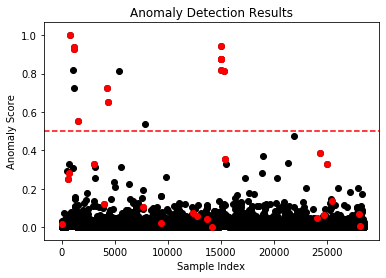

In [206]:

# ________visualization________________________________________
# Visualize the anomaly scores
now=datetime.datetime.now()
formatted=now.strftime('%m_%d_%H_%M')

plt.figure()
plt.scatter(x,anomaly_scores,color='black')
plt.scatter(real_anomal_x,real_anomal_y, color='red') 
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection Results')
# save the graph
save_path = f'{log_path}AnomalyScore_{formatted}.png'
plt.savefig(save_path)
plt.show()

# 빨간색은 실제 anomal이다. 우리는 빨간선 위의 값들을 이상치로 분류하는데, 
# normal 중에 이상치로 분류된 값도 있고 우리가 잘 분류해낸 값도 있음을 확인할 수 있다.
# 다양한 파라미터를 튜닝해보면서 시각화가 어떻게 변하는지 보는 재미도 있다 ^^


## 다음시간용 복잡한 오토인코더 및 차원축소 활용...

In [ ]:
# 인코더 정의
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(30, 15)
        self.l2 = nn.Linear(15, 8)
        self.l3 = nn.Linear(8, 4)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        return x

# 디코더 정의
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(4, 8)
        self.l2 = nn.Linear(8, 15)
        self.l3 = nn.Linear(15, 30)
        self.relu = nn.ReLU()
        self.sigmoid=nn.Sigmoid()

    def forward(self, z):
        z = self.l1(z)
        z = self.relu(z)
        z = self.l2(z)
        z = self.relu(z)
        z = self.l3(z)
        z = self.relu(z)
        z= self.sigmoid(z)
        return z

#오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# 이런 식으로 인코더와 디코더를 따로 정의한다면
# 나중에 인코더의 차원축소만 필요할 때, 굳이 오토인코더를 통째로 돌리지 않고
# 인코더만 불러서 돌릴 수 있다.
# 더 복잡한 모델을 짤 수 있는 것도 덤